#Boosting implementation, example and diagnostic - spam data

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
import sklearn.metrics as metrics 
import pdb
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D
from boosting import AdaBoostBinaryClassifier

In [8]:
%matplotlib inline

In [3]:
from sklearn.cross_validation import train_test_split

data = np.genfromtxt('spam.csv', delimiter=',')

y = data[:, -1]
x = data[:, 0:-1]

train_x, test_x, train_y, test_y = train_test_split(x, y)

In [5]:
print 'own implementation'
my_ada = AdaBoostBinaryClassifier(n_estimators=50)
my_ada.fit(train_x, train_y)
my_ada.predict(test_x)
print "  Accuracy:", my_ada.score(test_x, test_y)

print 'sklearn'
ada = AdaBoostClassifier(n_estimators=50)
ada.fit(train_x, train_y)
ada.predict(test_x)
print "  Accuracy:", ada.score(test_x, test_y)

own implementation
  Accuracy: 0.92180712424
sklearn
  Accuracy: 0.933970460469


In [6]:
def stage_score_plot(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    pred_y_test = model.staged_predict(test_x)
    iterations = []
    test_misclassification = []
       
    for i, val in enumerate(pred_y_test):
        iterations.append(i)
        misclass = 1 - metrics.accuracy_score(test_y, val)
        test_misclassification.append(misclass)
    
    model_n = model.__class__.__name__
    try:
        model_d = model.max_depth
    except:
        model_d = ''

    plt.plot(iterations, test_misclassification, label='%s %s' %(model_n, model_d))

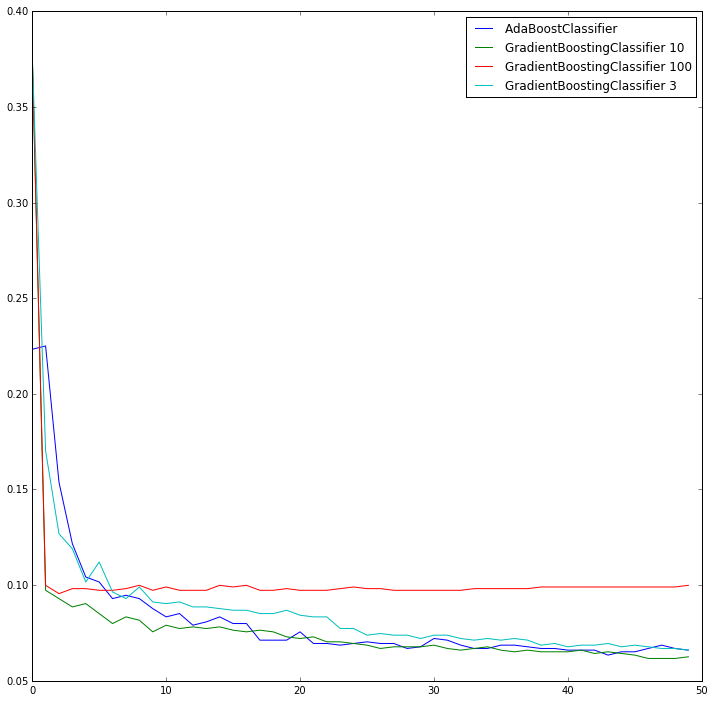

In [9]:
plt.figure(figsize=(12,12))    
#ada
ada = AdaBoostClassifier(n_estimators=50)    
stage_score_plot(ada, train_x, train_y, test_x, test_y)
#grad
gdbc = GradientBoostingClassifier(n_estimators=50,max_depth=10)
stage_score_plot(gdbc, train_x, train_y, test_x, test_y)
#grad
gdbc = GradientBoostingClassifier(n_estimators=50,max_depth=100)
stage_score_plot(gdbc, train_x, train_y, test_x, test_y)

gdbc = GradientBoostingClassifier(n_estimators=50)
stage_score_plot(gdbc, train_x, train_y, test_x, test_y)

plt.legend()

####Tree is too deep it's overfitting the data 

In [10]:
gdbc_grid = {'learning_rate': [0.05 ,0.1, 0.2],
            'min_samples_split': [1, 2, 4],
            'min_samples_leaf': [1, 2, 4],
            'n_estimators': [10, 50, 100, 150],
            'random_state': [1]}

gdbc_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             gdbc_grid,
                             verbose=True,
                             scoring='accuracy')

gdbc_gridsearch.fit(train_x, train_y)

print "best parameters:", gdbc_gridsearch.best_params_ #optimal params for rf

best_gdbc_model = gdbc_gridsearch.best_estimator_

print best_gdbc_model.score(test_x, test_y)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   34.3s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  3.7min finished


Fitting 3 folds for each of 108 candidates, totalling 324 fits
best parameters: {'min_samples_split': 4, 'n_estimators': 150, 'learning_rate': 0.2, 'random_state': 1, 'min_samples_leaf': 1}
0.941789748045


###Feature importance

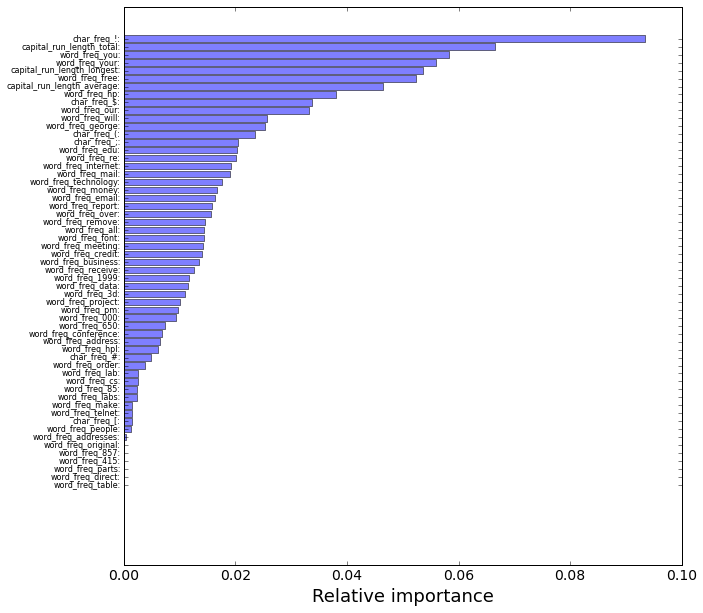

In [15]:
df = pd.read_csv('cols.csv')

col_names = df['0.'].values
# sort importances
best_gbdr_model = GradientBoostingClassifier(min_samples_split= 1, n_estimators= 150, 
    learning_rate= 0.2, random_state= 1, min_samples_leaf = 4).fit(train_x,train_y)
indices = np.argsort(best_gbdr_model.feature_importances_)
# plot as bar chart
figure = plt.figure(figsize=(10,10))
plt.barh(np.arange(len(col_names)), best_gbdr_model.feature_importances_[indices],
         align='center', alpha=.5)
plt.yticks(np.arange(len(col_names)), np.array(col_names)[indices], fontsize=8)
plt.xticks(fontsize=14)
_ = plt.xlabel('Relative importance', fontsize=18)

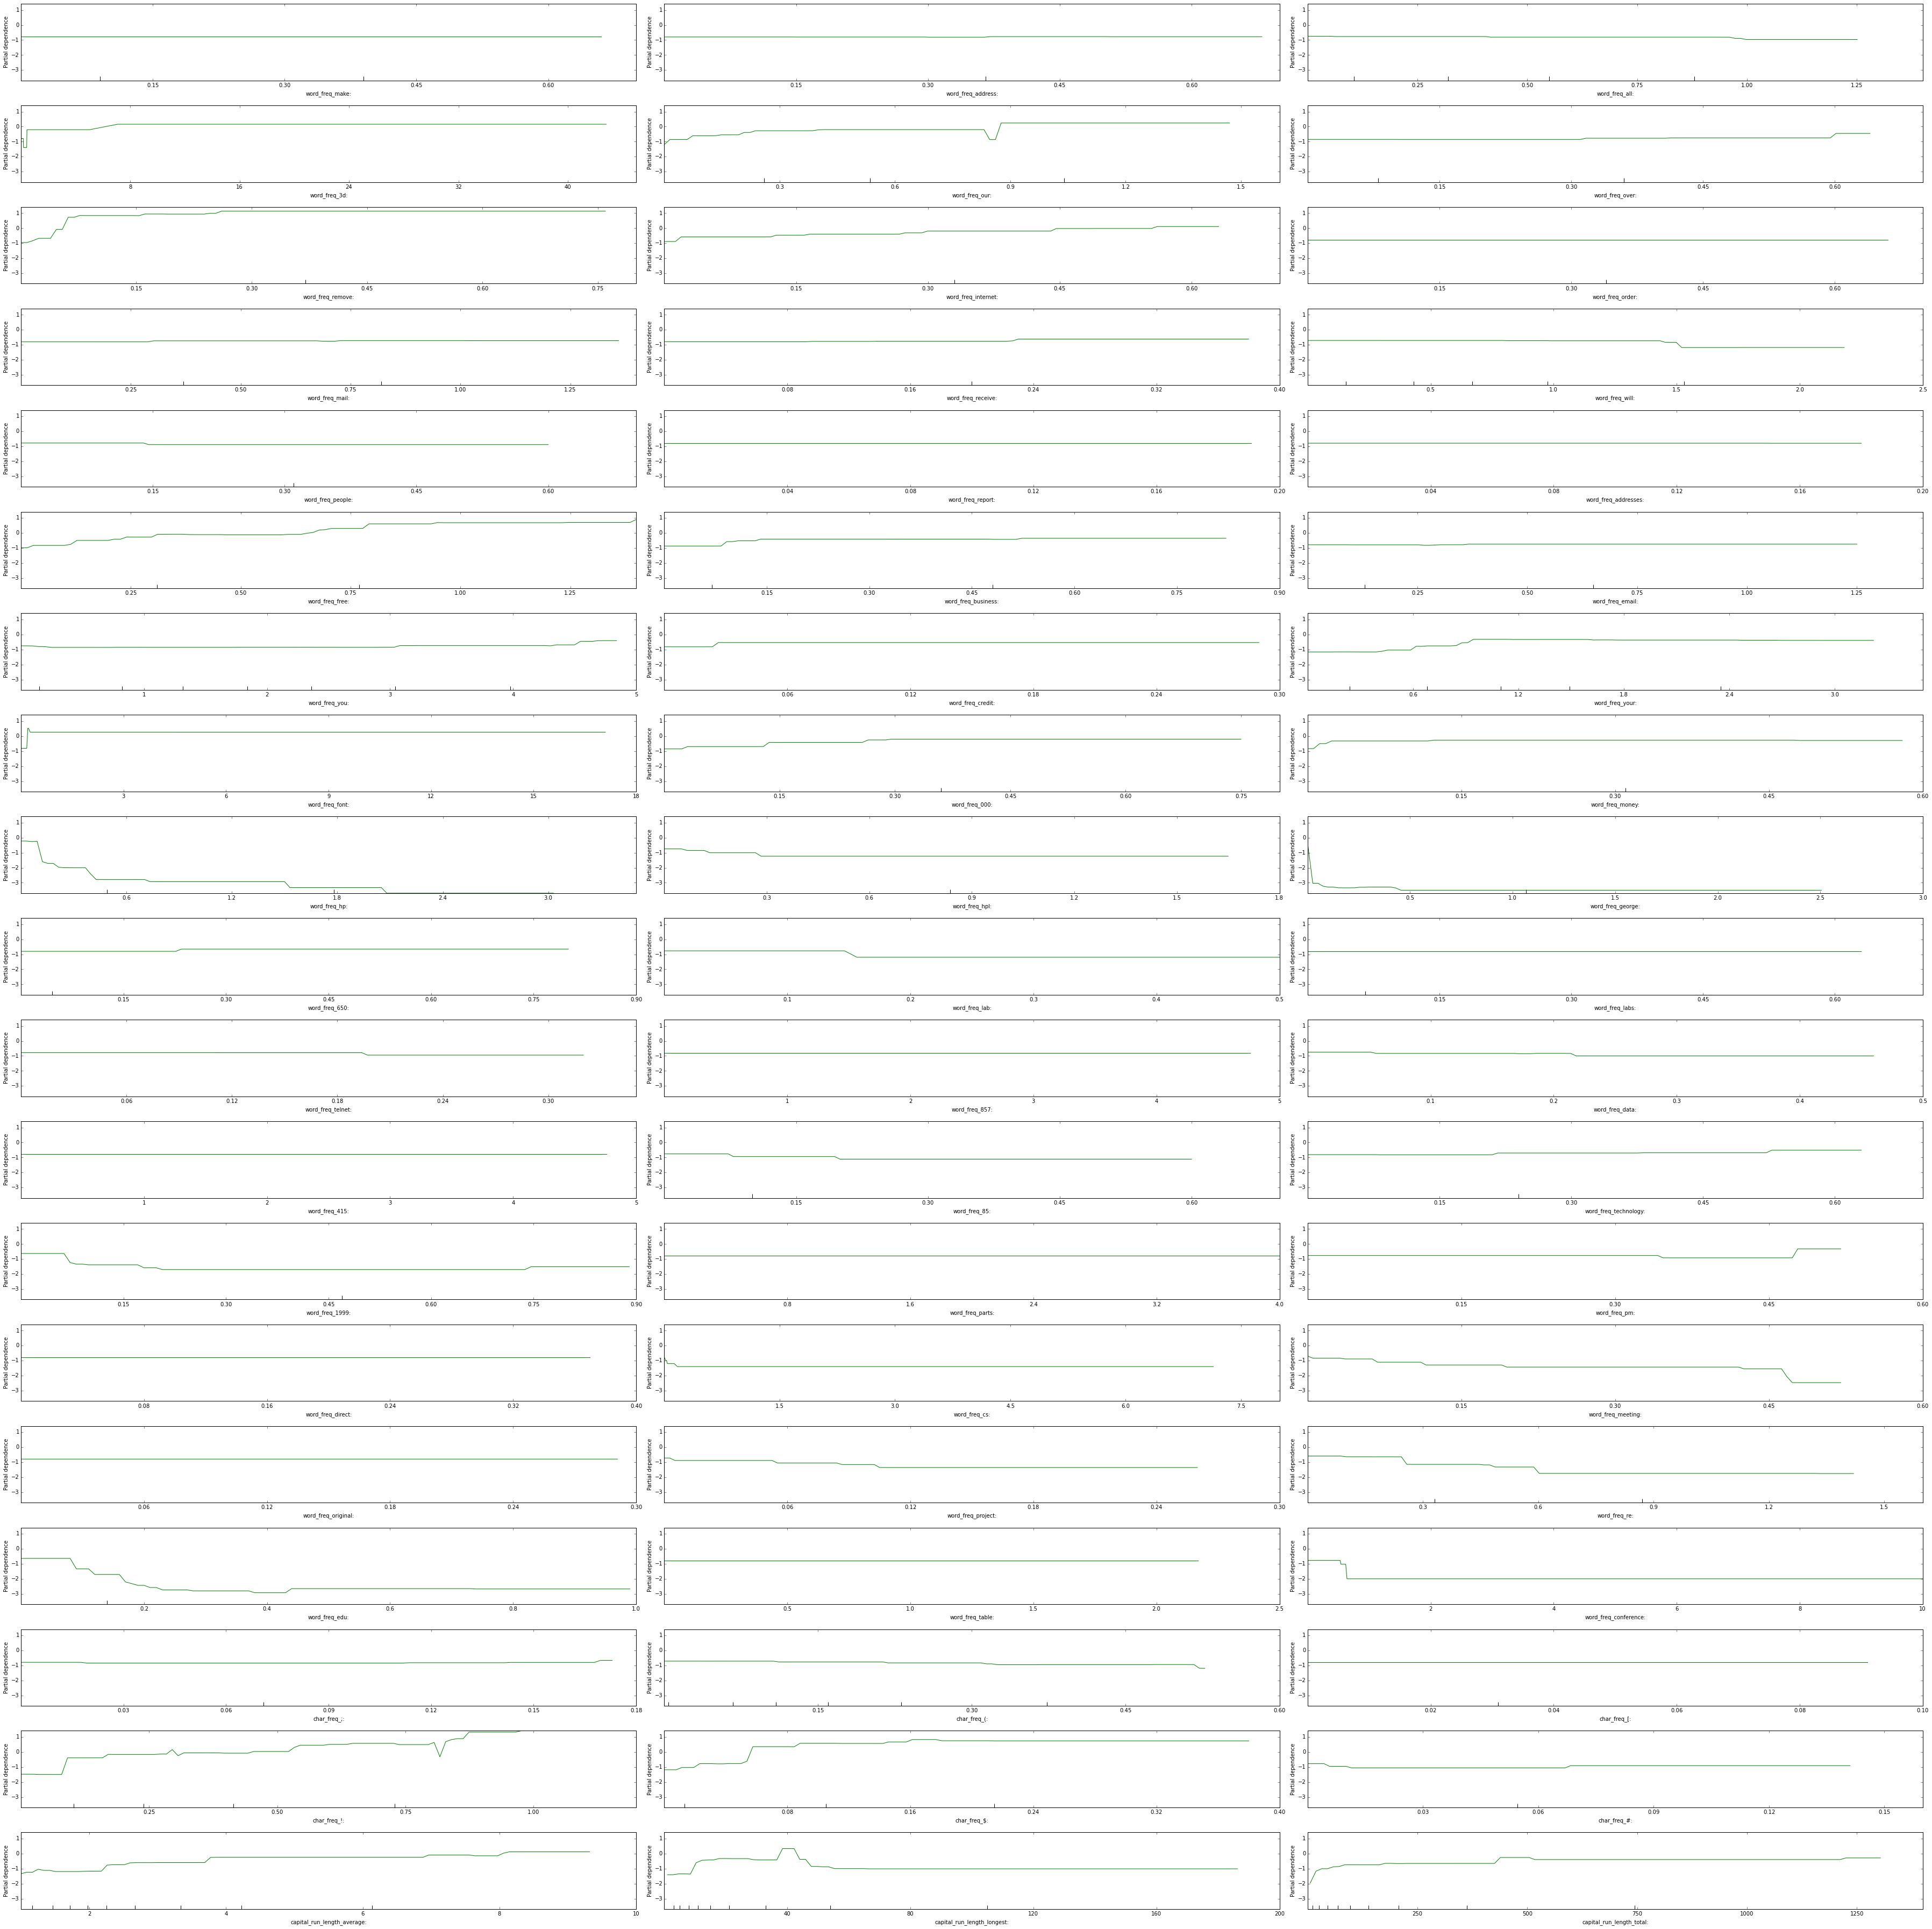

In [22]:
fig, axs = plot_partial_dependence(best_gbdr_model, train_x, 
                                   range(x.shape[1]),
                                   feature_names=col_names, figsize=(50, 50))

fig.tight_layout()

________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



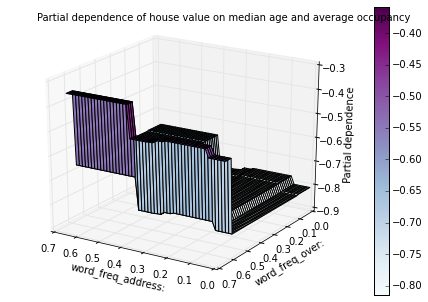

In [24]:
print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (1, 5)
pdp, (x_axis, y_axis) = partial_dependence(best_gdbc_model, target_feature,
                                           X=train_x, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(col_names[target_feature[0]])
ax.set_ylabel(col_names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median age and '
            'average occupancy')
plt.subplots_adjust(top=0.9)

plt.show()